In [95]:
# -*- coding: utf-8 -*- 
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, auc, roc_curve
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold,SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
from matplotlib import colors
%config InlineBackend.figure_format = 'png'
%matplotlib inline
import joblib
mpl.rcParams.update({'xtick.labelsize':16,
                     'ytick.labelsize':16})          
plt.rcParams['axes.unicode_minus'] = False   #用来正常显示负号

In [140]:
# # 数据读取
data = pd.read_excel(r'../数据/Q1_数据处理.xlsx')
data_train = data.iloc[:, 2:-1]  #标签
data_target = data.iloc[:, -1]
scale = StandardScaler()
data_train = scale.fit_transform(data_train)
x_train, x_test, y_train, y_test = train_test_split(data_train, data_target, test_size= 0.2, random_state= 100)

In [109]:
def draw_h2d(ax,Y_pre,Y, title):  # h-2d
    train_r2 = abs(r2_score(Y, Y_pre) )
    RMSE = (mean_squared_error(Y,Y_pre)**0.5)
    c = ax.hist2d(Y, Y_pre, bins=5, cmap='YlGnBu')
    ax.plot(Y,Y,c='#a61b29',label='y=x')
    ax.set_title(title+'R=%.3f RMSE=%.3f' % (train_r2**0.5,RMSE),loc='left',fontsize =15,fontweight='heavy')
    ax.set_ylim(0, np.max(Y))
    ax.set_xlim(0, np.max(Y))
    ax.set_xlabel('True Value ')
    ax.set_ylabel('Predicted Value')
    ##实际倾向率
    variance = np.var(Y, ddof=1)         # 计算方差，doff为贝塞尔（无偏估计）校正系数
    covariance = np.cov(Y, Y_pre)[0][1]  # 计算协方差
    w = covariance / variance
    b = np.mean(Y_pre) - w * np.mean(Y)
    y_line = w * Y+ b
    if b<0:
        ax.plot(Y, y_line, c='#15559a',label='y={}x{}'.format(round(w,4),round(b,4)))
    else:
        ax.plot(Y, y_line, c='#15559a',label='y={}x+{}'.format(round(w,4),round(b,4)))
    ax.legend(fontsize = 15)
    return c

def draw_h2d_plus(Classifier, y_pre, y_pre_train):
    mpl.rcParams.update(mpl.rcParamsDefault)  #还原默认绘图风格
    mpl.rc('font', size=15, weight='normal')  #设置全局字体大小 
    fig = plt.figure(figsize=(10,12))
    fig_ax1 = fig.add_axes([0.1, 0.6, 0.4, 0.3]) 
    fig_ax2 = fig.add_axes([0.6, 0.6, 0.4, 0.3])
    c = draw_h2d(fig_ax1, y_pre_train, y_train, Classifier + '_train:')  #随模型修改------
    c2= draw_h2d(fig_ax2, y_pre, y_test, Classifier + '_test:')
    cax = plt.axes([0.13,0.53 , 0.8, 0.02])
    cbar=plt.colorbar(c[3],cax=cax, orientation='horizontal')
    cbar.set_label("density")
    plt.show()

In [110]:
def calculate_auc(y_test, pred): #绘制roc曲线   
    fpr, tpr, thersholds = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize= (6, 6))
    plt.plot(fpr, tpr, color= '#15559a', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], color= '#d1c2d3', linestyle= '--')
    plt.show()

#### 基础分类器

c:\Users\syh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:32:21] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
训练集准确率： 1.0
测试集准确率： 0.96


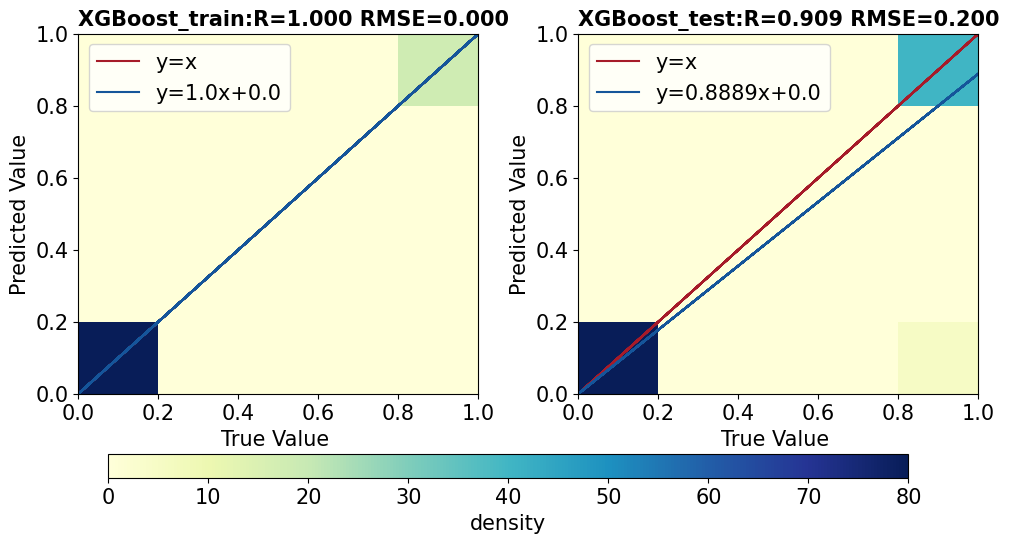

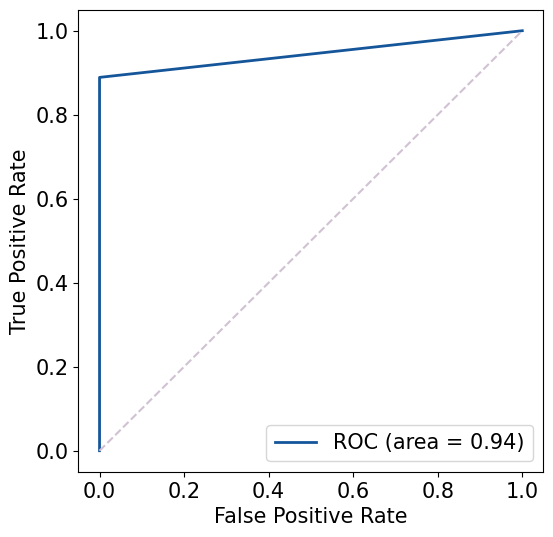

训练集准确率： 1.0
测试集准确率： 0.96


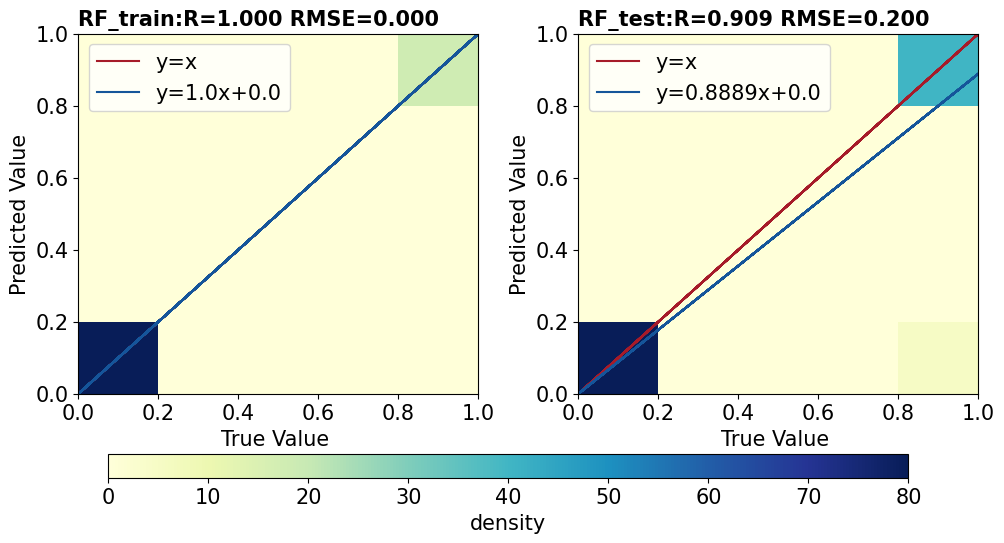

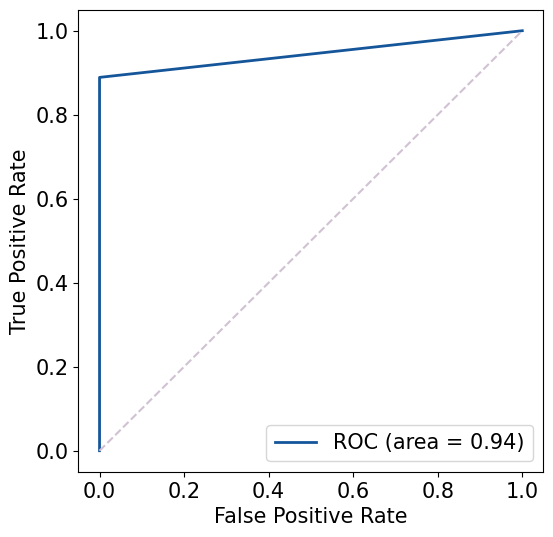

训练集准确率： 1.0
测试集准确率： 0.92


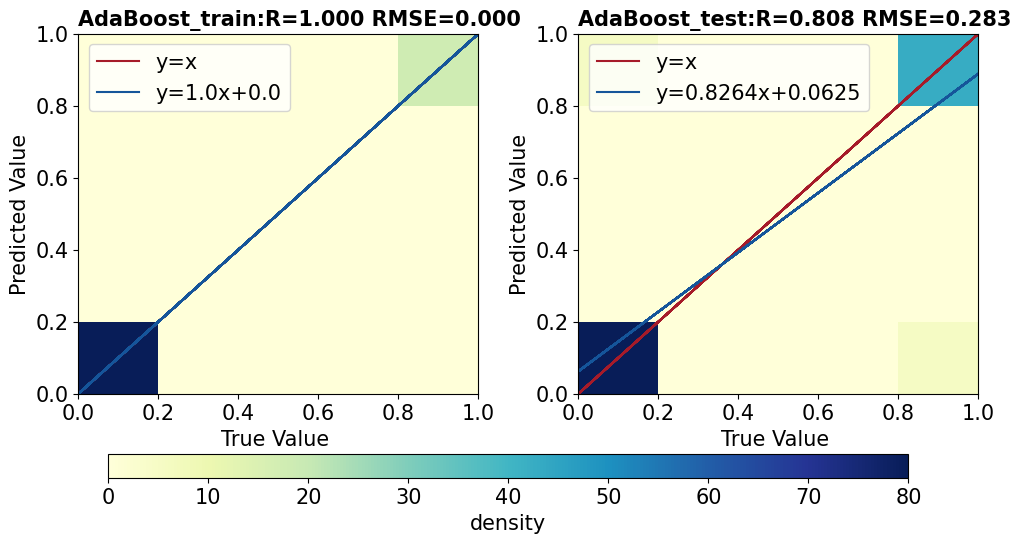

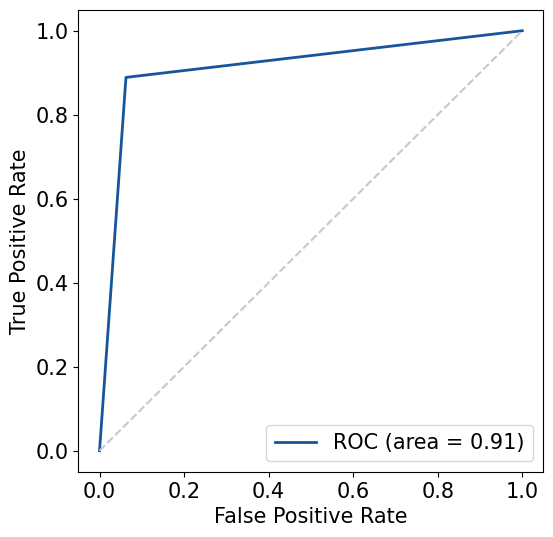

训练集准确率： 0.9387755102040817
测试集准确率： 0.8


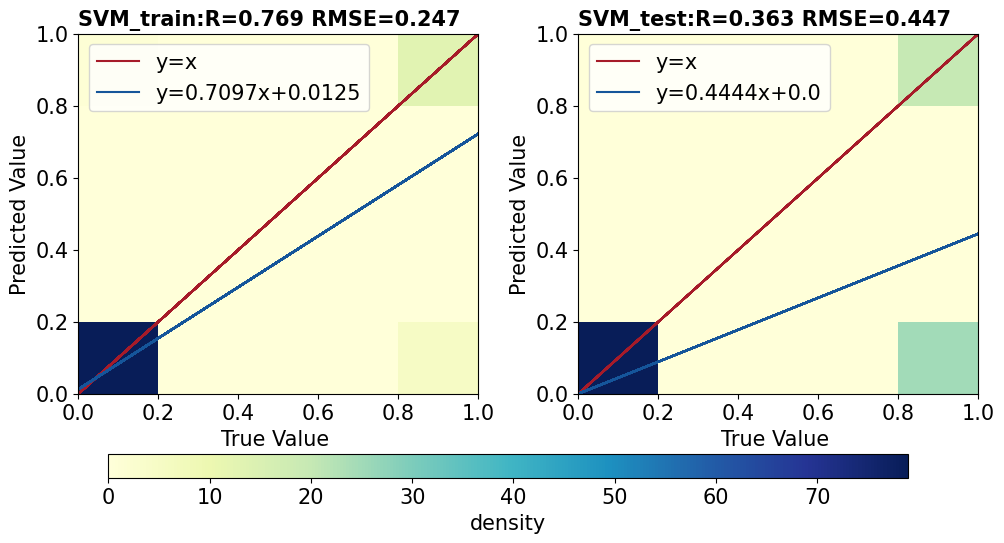

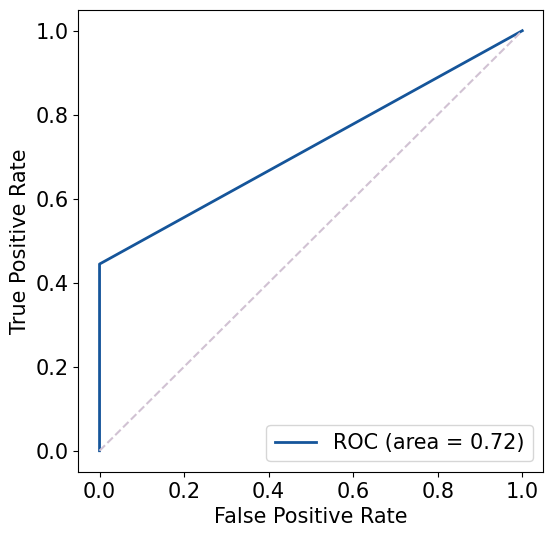

训练集准确率： 0.9795918367346939
测试集准确率： 0.88


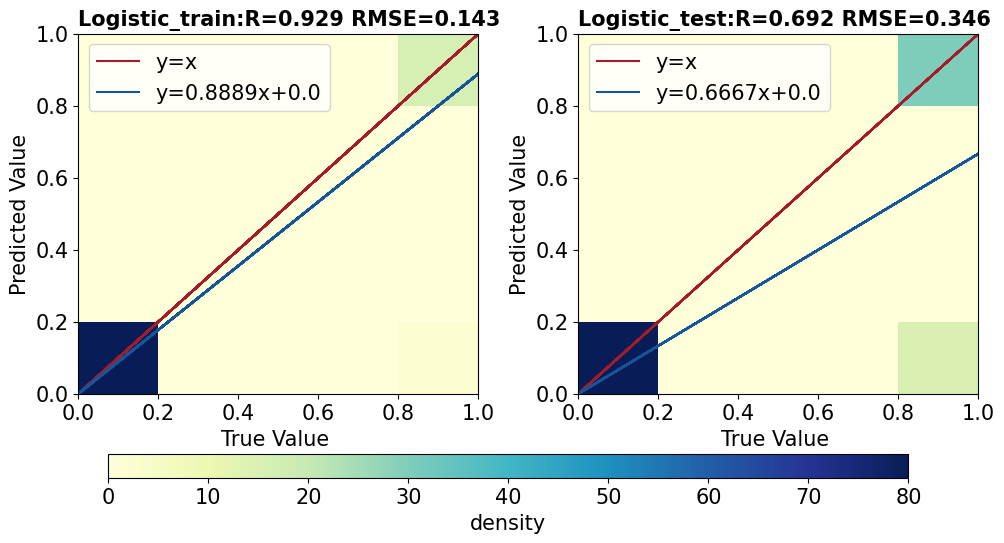

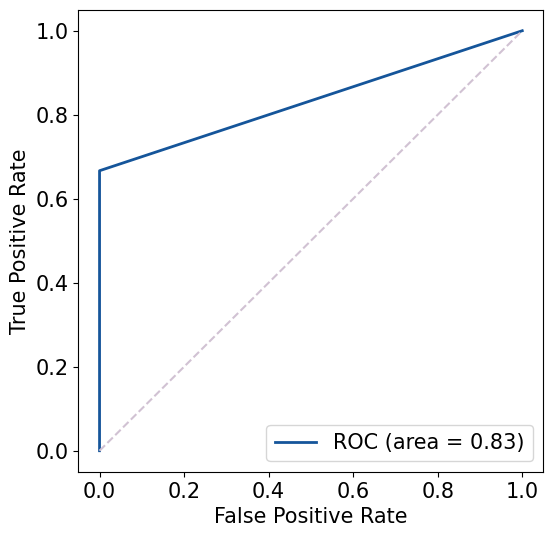

In [137]:
clfs = [XGBClassifier(), RandomForestClassifier(random_state= 100),AdaBoostClassifier(), SVC(probability= True), LogisticRegression()]
clfs_str = ['XGBoost','RF' ,'AdaBoost', 'SVM', 'Logistic', 'Voting']
accuracy_score_train = []
accuracy_score_test = []
for i in np.arange(0, 5):
    clf = clfs[i]
    clf.fit(x_train, y_train)
    y_pre = clf.predict(x_test)
    y_pre_train = clf.predict(x_train)       
    accuracy_score_train.append(accuracy_score(y_train, y_pre_train)) #训练集准确率
    accuracy_score_test.append(accuracy_score(y_test, y_pre))         #测试集准确率
    print('训练集准确率：', accuracy_score_train[i])
    print('测试集准确率：', accuracy_score_test[i])

    # 储存模型
    # joblib.dump(filename= clfs_str[i] + '.model', value= clf) #保存模型
    # 绘图-h2d
    draw_h2d_plus(Classifier= clfs_str[i], y_pre= y_pre, y_pre_train= y_pre_train)
    calculate_auc(y_test= y_test, pred= y_pre)

#### Voting

c:\Users\syh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:17:27] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
训练集准确率： 0.9897959183673469
测试集准确率： 0.96


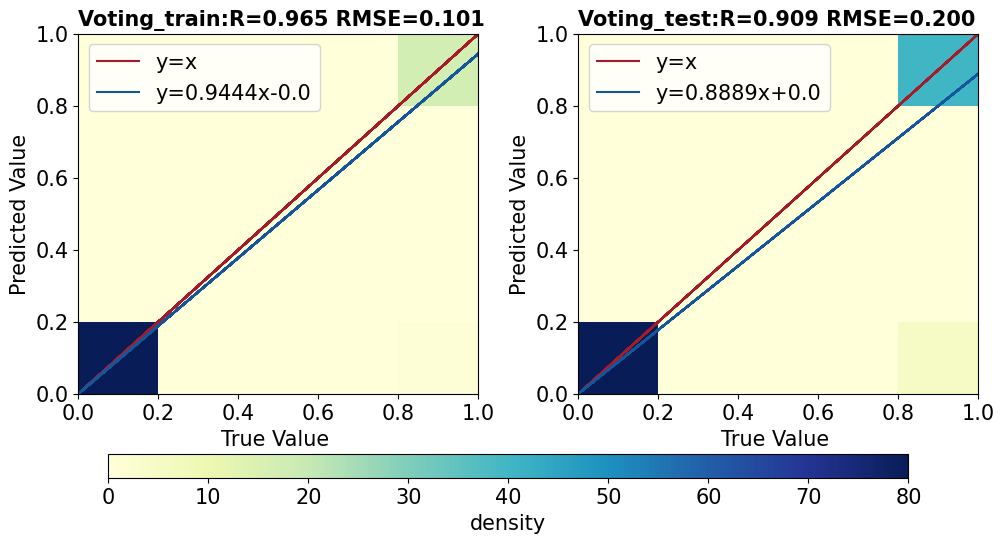

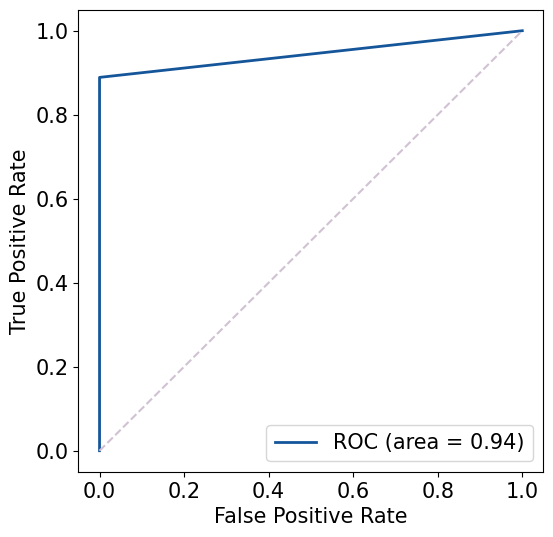

In [124]:
clf_weights = accuracy_score_train/np.sum(accuracy_score_train) #各分类器权重
clf_voting = VotingClassifier(estimators=[('xgb', clfs[0]),
                                          ('rf', clfs[1]),
                                          ('adab', clfs[2]),
                                          ('svc', clfs[3]),
                                          ('lr', clfs[4])], 
                                          voting= 'soft',
                                          weights= clf_weights) #投票方式：soft
clf_voting.fit(x_train, y_train)
y_pre_train = clf_voting.predict(x_train)   #训练集预测
y_pre = clf_voting.predict(x_test)          #测试集预测
accuracy_score_train.append(accuracy_score(y_train, y_pre_train)) #训练集准确率
accuracy_score_test.append(accuracy_score(y_test, y_pre))         #测试集准确率
print('训练集准确率：', accuracy_score_train[5])
print('测试集准确率：', accuracy_score_test[5])
# 储存模型
# joblib.dump(filename= 'voting.model', value= clf)
#绘图-h2d、Roc
draw_h2d_plus(Classifier= 'Voting', y_pre= y_pre, y_pre_train= y_pre_train)
calculate_auc(y_test= y_test, pred= y_pre)

In [125]:
model_data = pd.DataFrame(data= {'model':clfs_str, 
                                 'accuracy_score_train':accuracy_score_train,
                                 'accuracy_score_test':accuracy_score_test})
model_data.to_excel(r'../数据/Q1_model_score.xlsx', index= False)

#### 违约风险统计分析

In [138]:
# 数据读取
data = pd.read_excel(r'../数据/Q1_数据处理.xlsx')
data_Q1 = pd.read_excel(r'../数据/附件1：123家有信贷记录企业的相关数据.xlsx', sheet_name= '企业信息')
data_train = data.iloc[:, 2:-1]  #标签
scale = StandardScaler()
data_train = scale.fit_transform(data_train)

data_Q1['是否违约'].loc[data_Q1['是否违约']=='是'] = 1
data_Q1['是否违约'].loc[data_Q1['是否违约']=='否'] = 0
# 模型引用
model = joblib.load(r'../代码/voting.model')
# 预测
pred = model.predict_proba(data_train)[:,-1]
data_Q1['pred'] = np.round(pred, 6)

In [133]:
# 风险统计分析
count = []
mean = []
std = []
min = []
max = []
credit = ['A', 'B', 'C', 'D']
for i in credit:
    data_credit = data_Q1.loc[data_Q1['信誉评级']== i].iloc[:, 2:]
    count.append(len(data_credit))
    mean.append(data_credit.iloc[:,2].mean())
    std.append(data_credit.iloc[:,2].std())
    min.append(data_credit.iloc[:,2].min())
    max.append(data_credit.iloc[:,2].max())
data_analysis = pd.DataFrame(data= {'信誉等级':credit,
                                    'Count':count,
                                    'Mean':mean,
                                    'Std':std,
                                    'Min':min,
                                    'Max':max})
# data_analysis.to_excel(r'../数据/Q1_不同信誉评级违约风险分析.xlsx',index= False)
data_analysis

,信誉等级,Count,Mean,Std,Min,Max
0,A,27,0.001583,0.001062,0.000000,0.003422
1,B,38,0.020880,0.011932,0.000060,0.044209
2,C,34,0.155143,0.108485,0.000013,0.457068
3,D,24,0.787431,0.175823,0.195973,0.979566
